In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
df = pd.read_csv('cleaned_df_3.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df.dropna(inplace = True)

In [3]:
def assign_year(date):
    if date.year == 2009:
        return 0  
    elif date.year == 2010:
        return 1  
    elif date.year == 2011:
        return 2 
    elif date.year == 2012:
        return 3 
    elif date.year == 2013:
        return 4 
    elif date.year == 2014:
        return 5
    else:
        return 6
        
    
df['Year'] = df['pickup_datetime'].apply(assign_year)
df.rename({'distance_km' : 'Haversine_dist'}, axis = 1, inplace = True)
df['Haversine_dist_sq'] = df['Haversine_dist']**2
# df['Haversine_dist_in'] = 1/df['Haversine_dist']
# df['Haversine_dist_lg'] = np.log(df['Haversine_dist'])


df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,time_category,day_category,cab_category,days_passed,Haversine_dist,Year,Haversine_dist_sq
count,134048.000000,134048.000000,134048.000000,134048.000000,134048.000000,134048.000000,134048.000000,134048.000000,134048.000000,134048.000000,134048.000000,134048.000000,134048.000000
mean,8.974555,-73.980796,40.752297,-73.979700,40.752334,1.692715,1.593593,0.283025,0.091639,1179.017456,2.427400,2.751037,7.184700
std,3.323570,0.020687,0.022894,0.021527,0.024213,1.307416,1.079051,0.450470,0.288516,675.886882,1.136855,1.861165,6.652207
min,4.500000,-75.387785,40.350780,-75.375315,40.350192,1.000000,0.000000,0.000000,0.000000,0.000000,0.928928,0.000000,0.862907
25%,6.500000,-73.992547,40.737802,-73.991989,40.737711,1.000000,1.000000,0.000000,0.000000,598.000000,1.497148,1.000000,2.241453
50%,8.100000,-73.982595,40.753082,-73.981716,40.753580,1.000000,2.000000,0.000000,0.000000,1183.000000,2.148618,3.000000,4.616558
75%,10.900000,-73.971027,40.766562,-73.969811,40.766802,2.000000,2.000000,1.000000,0.000000,1757.000000,3.146015,4.000000,9.897410
max,24.100000,-72.750302,41.164293,-72.759090,41.158393,6.000000,3.000000,1.000000,1.000000,2371.000000,5.396645,6.000000,29.123780


In [4]:
df['time_category'] = 0   # for 11:00 pm - 6:00 am

# 8:00 am - 10:00 am -> 1
df.loc[(df['pickup_datetime'].dt.time >= pd.to_datetime('08:00').time()) &
       (df['pickup_datetime'].dt.time < pd.to_datetime('10:00').time()), 'time_category'] = 1

# 10:00 am - 5:00 pm -> 2
df.loc[(df['pickup_datetime'].dt.time >= pd.to_datetime('10:00').time()) &
       (df['pickup_datetime'].dt.time < pd.to_datetime('17:00').time()), 'time_category'] = 2

# 5:00 pm - 7:00 pm -> 1
df.loc[(df['pickup_datetime'].dt.time >= pd.to_datetime('17:00').time()) &
       (df['pickup_datetime'].dt.time < pd.to_datetime('19:00').time()), 'time_category'] = 1

# 7:00 pm - 11:00 pm -> 3
df.loc[(df['pickup_datetime'].dt.time >= pd.to_datetime('19:00').time()) &
       (df['pickup_datetime'].dt.time < pd.to_datetime('23:00').time()), 'time_category'] = 3

# 6:00 am - 8:00 am -> 1
df.loc[(df['pickup_datetime'].dt.time >= pd.to_datetime('06:00').time()) &
       (df['pickup_datetime'].dt.time < pd.to_datetime('08:00').time()), 'time_category'] = 4


# For getting the weekdays and weekend separation, we have day_category which is
# 0 -> for weekdays
# 1 -> for weekends

df['cab_category'] = df['passenger_count'].apply(lambda x: 2 if x >= 5 else 1)
df.loc[df['passenger_count'] == 1, 'cab_category'] = 0
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,time_category,day_category,cab_category,days_passed,Haversine_dist,Year,Haversine_dist_sq
0,7.7,2009-01-01 15:13:51+00:00,-73.986937,40.756585,-73.994463,40.733073,1,2,0,0,0,2.690195,0,7.237148
1,4.9,2009-01-01 16:17:11+00:00,-73.988906,40.736729,-73.981043,40.747090,1,2,0,0,0,1.328961,0,1.766138
2,9.3,2009-01-01 12:03:00+00:00,-73.967622,40.801990,-73.941178,40.788587,1,2,0,0,0,2.678890,0,7.176453
3,4.5,2009-01-01 16:16:00+00:00,-73.979602,40.743568,-73.991972,40.748805,5,2,0,2,0,1.193746,0,1.425028
4,8.5,2009-01-01 17:19:56+00:00,-73.972600,40.749377,-73.981393,40.721997,1,1,0,0,0,3.133362,0,9.817956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134043,19.0,2015-06-30 11:53:15+00:00,-73.986099,40.756897,-74.011124,40.713314,1,2,0,0,2371,5.285004,6,27.931263
134044,11.0,2015-06-30 21:55:11+00:00,-73.965515,40.713600,-73.960236,40.686615,1,3,0,0,2371,3.033442,6,9.201769
134045,9.5,2015-06-30 21:39:29+00:00,-73.982468,40.772266,-73.976784,40.790325,2,3,0,1,2371,2.064285,6,4.261273
134046,12.0,2015-06-30 18:58:15+00:00,-74.002357,40.728298,-73.973396,40.743832,1,1,0,0,2371,2.989577,6,8.937571


In [5]:
df_encoded = pd.get_dummies(df, columns=['day_category', 'time_category', 'cab_category', 'Year'], drop_first=True)
# Check and convert columns to numeric (especially the target and features)
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')

# Drop rows with any NaN values (optional, if missing data exists)
df_encoded.dropna(inplace=True)
df_encoded

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,days_passed,Haversine_dist,Haversine_dist_sq,...,time_category_3,time_category_4,cab_category_1,cab_category_2,Year_1,Year_2,Year_3,Year_4,Year_5,Year_6
0,7.7,1230822831000000000,-73.986937,40.756585,-73.994463,40.733073,1,0,2.690195,7.237148,...,0,0,0,0,0,0,0,0,0,0
1,4.9,1230826631000000000,-73.988906,40.736729,-73.981043,40.747090,1,0,1.328961,1.766138,...,0,0,0,0,0,0,0,0,0,0
2,9.3,1230811380000000000,-73.967622,40.801990,-73.941178,40.788587,1,0,2.678890,7.176453,...,0,0,0,0,0,0,0,0,0,0
3,4.5,1230826560000000000,-73.979602,40.743568,-73.991972,40.748805,5,0,1.193746,1.425028,...,0,0,0,1,0,0,0,0,0,0
4,8.5,1230830396000000000,-73.972600,40.749377,-73.981393,40.721997,1,0,3.133362,9.817956,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134043,19.0,1435665195000000000,-73.986099,40.756897,-74.011124,40.713314,1,2371,5.285004,27.931263,...,0,0,0,0,0,0,0,0,0,1
134044,11.0,1435701311000000000,-73.965515,40.713600,-73.960236,40.686615,1,2371,3.033442,9.201769,...,1,0,0,0,0,0,0,0,0,1
134045,9.5,1435700369000000000,-73.982468,40.772266,-73.976784,40.790325,2,2371,2.064285,4.261273,...,1,0,1,0,0,0,0,0,0,1
134046,12.0,1435690695000000000,-74.002357,40.728298,-73.973396,40.743832,1,2371,2.989577,8.937571,...,0,0,0,0,0,0,0,0,0,1


In [6]:
y = df_encoded['fare_amount']
X = df_encoded.drop(['days_passed','passenger_count','fare_amount', 'pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1)
X = sm.add_constant(X)  # Add a constant (intercept) term
display(X)
display(y)

,const,Haversine_dist,Haversine_dist_sq,day_category_1,time_category_1,time_category_2,time_category_3,time_category_4,cab_category_1,cab_category_2,Year_1,Year_2,Year_3,Year_4,Year_5,Year_6
0,1.0,2.690195,7.237148,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1.0,1.328961,1.766138,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1.0,2.678890,7.176453,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1.0,1.193746,1.425028,0,0,1,0,0,0,1,0,0,0,0,0,0
4,1.0,3.133362,9.817956,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134043,1.0,5.285004,27.931263,0,0,1,0,0,0,0,0,0,0,0,0,1
134044,1.0,3.033442,9.201769,0,0,0,1,0,0,0,0,0,0,0,0,1
134045,1.0,2.064285,4.261273,0,0,0,1,0,1,0,0,0,0,0,0,1
134046,1.0,2.989577,8.937571,0,1,0,0,0,0,0,0,0,0,0,0,1


0          7.7
1          4.9
2          9.3
3          4.5
4          8.5
          ... 
134043    19.0
134044    11.0
134045     9.5
134046    12.0
134047    20.0
Name: fare_amount, Length: 134048, dtype: float64

In [7]:
X[X.select_dtypes(include=['bool']).columns] = X.select_dtypes(include=['bool']).astype(int)
# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                 1.337e+04
Date:                Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                        10:44:02   Log-Likelihood:            -2.8989e+05
No. Observations:              134048   AIC:                         5.798e+05
Df Residuals:                  134032   BIC:                         5.800e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.0392      0.03

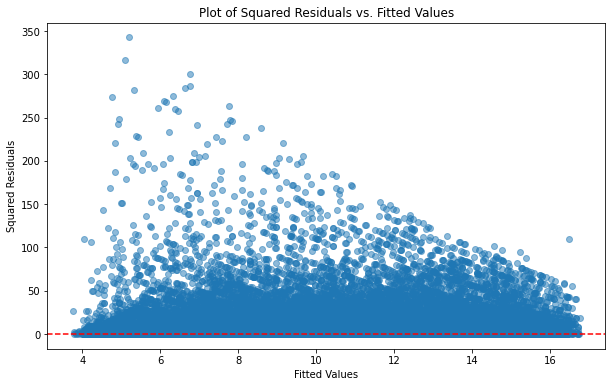

In [8]:
# Plotting squared residuals vs fitted values
fitted_values = model.fittedvalues
residuals = model.resid

# Step 2: Calculate squared residuals
squared_residuals = residuals ** 2

# Step 3: Plot squared residuals vs. fitted values
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, squared_residuals, alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Squared Residuals')
plt.title('Plot of Squared Residuals vs. Fitted Values')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


In [9]:
# Performing the Goldfeld-Quandt test
# You can specify the split point with the `split` parameter or leave it for default
gq_test = sm.stats.diagnostic.het_goldfeldquandt(y, X, alternative='two-sided')

# Extracting the results
gq_statistic, p_value, _ = gq_test

# Displaying the test results
print("Goldfeld-Quandt Test Statistic:", gq_statistic)
print("p-value:", p_value)

# Interpreting the p-value
if p_value < 0.05:
    print("Evidence of heteroskedasticity (reject null hypothesis).")
else:
    print("No evidence of heteroskedasticity (fail to reject null hypothesis).")


Goldfeld-Quandt Test Statistic: 1.5372544101933938
p-value: 0.0
Evidence of heteroskedasticity (reject null hypothesis).


In [10]:
# White's test
from statsmodels.stats.diagnostic import het_white

# Getting residuals and exogenous (independent) variables
exog = model.model.exog
residuals = model.resid

# Performing White's test
white_test = het_white(residuals, exog)

# Extracting the results
white_statistic, white_p_value, _, _ = white_test

# Displaying the test results
print("White's Test Statistic:", white_statistic)
print("p-value:", white_p_value)

# Interpretation of the p-value
if white_p_value < 0.05:
    print("Evidence of heteroskedasticity (reject null hypothesis).")
else:
    print("No evidence of heteroskedasticity (fail to reject null hypothesis).")


White's Test Statistic: 4229.301747092277
p-value: 0.0
Evidence of heteroskedasticity (reject null hypothesis).


In [11]:
# Check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

              Feature        VIF
0               const  44.080734
1      Haversine_dist  25.004179
2   Haversine_dist_sq  24.976077
3      day_category_1   1.046118
4     time_category_1   1.849257
5     time_category_2   2.065426
6     time_category_3   1.908690
7     time_category_4   1.298885
8      cab_category_1   1.041781
9      cab_category_2   1.029182
10             Year_1   1.679929
11             Year_2   1.707656
12             Year_3   1.720852
13             Year_4   1.708790
14             Year_5   1.684231
15             Year_6   1.354150


In [12]:
# Performing Durbin-Watson test
dw_statistic = sm.stats.durbin_watson(model.resid)

# Displaying the test result
print("Durbin-Watson Statistic:", dw_statistic)

# Interpretation of the Durbin-Watson statistic
if dw_statistic < 1.5:
    print("Evidence of positive autocorrelation.")
elif dw_statistic > 2.5:
    print("Evidence of negative autocorrelation.")
else:
    print("No evidence of significant autocorrelation.")


Durbin-Watson Statistic: 1.9265387541740895
No evidence of significant autocorrelation.
